<a href="https://colab.research.google.com/github/guptuv/Inverted-Pendulum/blob/main/Copy_of_PID_controller_explorer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RoboLaunch Workshop Series: **Intro to PID Control**

If you didn't see the accompanying presentation with this Colab, you can watch it here: [**How to Control a Robot: Intuition for Feedback Control and PID**](https://youtu.be/dR0nTvZqabQ)

In this notebook you will explore the challenges of controlling a simple robot arm. You will write your own functions in Python that will move the arm with *finesse*, **precision**, and ***speed*** beyond your own abilities. We will walk you through the steps of coding and tuning your controller, as well as leave open questions for you to explore in an open-ended simulation.

### First, a Quick Google Colab Intro

A notebook is a list of cells. Cells contain either explanatory text or executable code and its output. Click a cell to select it.

Below is a **code cell** that prints "Hello World!". Click in the cell to select it and execute the contents in one of the following ways:

* Click the **Play icon** in the left gutter of the cell;
* Type **Cmd/Ctrl+Enter** to run the cell in place;
* Type **Shift+Enter** to run the cell and move focus to the next cell (adding one if none exists);

In [ ]:
# This is a comment
print('Hello World!')

Hello World!


Did you see the code cell print "Hello World!"? Great!

# Single Link Robot Arm

For our example system, we will use a single link robot arm. This is essentially a rod with one pivot at the end. At the pivot point there is a motor we can control in order to get the arm to rotate in either direction. This rotational force is called **torque**.

The angle of the arm is defined as in the image below (except we will be using radians rather than degrees):

<img src="https://raw.githubusercontent.com/bradygm/PID-controller-simulator/fc1fc67be86c934b0a07869eaddb00a79ff07488/media/armAngle.png" alt="drawing" width="200"/>

For the guided portion of this lesson, we will imagine that the arm is flat on the table and we can disregard gravity. You can add gravity in later in order for this to act more like a typical pendulum example.



## Imports, helper functions, and classes

We will start by running some code that will set a lot of things up for us. You can run all of these cells by just clicking on the **Play icon** below next to the text that reads "*7 cells hidden*". You won't see any outputs from running these cells. You can also feel free to open the cells later to look through the code and modify. You can collapse the cells again by clicking on the arrow next to the title of this text box.

##### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import math
from IPython.display import HTML, Javascript
from scipy import interpolate
from ipywidgets import interact, interactive, fixed, interact_manual, Video
import ipywidgets as widgets
import time
from scipy import signal
import urllib.request
import requests, warnings
from random import randrange

##### CustomInput Class, interpolation function, and display function

In [ ]:
class CustomInput:

    def __init__(self, min_val, max_val):
        self.a = widgets.FloatSlider(description='Input',min=min_val, max=max_val)
        self.values = np.array([[]])

        self.start_time = -1.0
        self.first_time = True

    def f(self, a):
        if self.first_time:
            self.first_time = False
            plt.plot(self.values[:,0], self.values[:,1])
            plt.xlabel("Seconds")
            plt.ylabel("Input")
            return

        if self.start_time == -1.0:
            self.start_time = time.time()

        self.values = np.append(self.values, [[time.time()-self.start_time, a]], axis=0)
        plt.plot(self.values[:,0], self.values[:,1], drawstyle="steps-pre")
        plt.xlabel("Seconds")
        plt.ylabel("Input")

    def record(self):
        self.values = np.empty((0,2), float)
        self.start_time = -1.0
        self.first_time = True

        out = widgets.interactive_output(self.f, {'a': self.a})

        # vid_out = widgets.Output(layout={'border': '1px solid black'})
        # with vid_out:
        #     display(Video.from_file("animation.mp4", play=True))
        # widgets.HBox([widgets.VBox([a]), out, vid_out])
        return widgets.HBox([widgets.VBox([self.a]), out])

In [ ]:
def interp_values(values, end_time, dt):
    # values_t = np.array(values)
    f = interpolate.interp1d(values[:,0], values[:,1], kind='previous', fill_value="extrapolate")
    time_list = np.arange(0, end_time, dt)
    return f(time_list)

In [ ]:
# def submit_response(Name="AnonUser", Error=99999999, P=0, D=0, verbose=False):
rand_id = randrange(9999)

def submit_response(Name="AnonymousUser", verbose=False):
    if Name=="AnonymousUser":
        Name += str(rand_id)
    end_time = 10
    period = 10
    start_angle = 0.0
    dt = 0.05
    time_list = np.arange(0, end_time, dt)
    list_len = len(time_list)
    total_error = 0

    # Initialize the RobotArm and save as my_robot_arm
    my_robot_arm = RobotArm(start_angle, dt)

    goal_ang_interp = signal.square(2 * np.pi * time_list/period)

    for i in range(list_len):
        total_error += abs(goal_ang_interp[i]-my_robot_arm.get_ang_position())*dt
        torque = pd_controller(P, D,
                            goal_ang_interp[i],
                            my_robot_arm.get_ang_position(),
                            my_robot_arm.get_ang_velocity())
        my_robot_arm.step_forward(torque)


    url = 'https://docs.google.com/forms/d/e/1FAIpQLSdRzW6JKXLfBW9q4KQCL6ijfs_NoAvpuXqCU-ik0H5XROilNA/viewform'
    submit_url = url.replace('/viewform', '/formResponse')
    form_data = {'draftResponse':[],
                'pageHistory':0}
    form_data['entry.1119491454'] = total_error
    form_data['entry.1429935538'] = Name
    form_data['entry.1469728088'] = P
    form_data['entry.1372586630'] = D
    print("User " + Name + " total error: " + str(total_error))
    if verbose:
        print(form_data)
    user_agent = {'Referer':url,
                  'User-Agent': "Mozilla/5.0 (X11; Linux i686) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/28.0.1500.52 Safari/537.36"}
    return requests.post(submit_url, data=form_data, headers=user_agent)

In [ ]:
#############################################
# Display the results
def display_results(goal_ang_interp):
    start = time.time()
    goal_list_size = len(goal_ang_interp)
    # arm sim
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(autoscale_on=False, xlim=(-my_robot_arm.length*1.2, my_robot_arm.length*1.2), ylim=(-my_robot_arm.length*1.2, my_robot_arm.length*1.2))
    ax.set_aspect('equal')


    if goal_list_size != 0:
        line7, = ax.plot([], [], 'o-', lw=6, color='C1', alpha=.2)
    line, = ax.plot([], [], 'o-', color='C0', lw=6)
    time_template = 'time = %.1fs'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


    def animate_arm(i):
        if goal_list_size != 0:
            thisx = [0, my_robot_arm.length*np.sin(goal_ang_interp[i])]
            thisy = [0, my_robot_arm.length*np.cos(goal_ang_interp[i])]
            line7.set_data(thisx, thisy)
        thisx = [0, my_robot_arm.length*np.sin(ang_hist[i])]
        thisy = [0, my_robot_arm.length*np.cos(ang_hist[i])]
        line.set_data(thisx, thisy)
        time_text.set_text(time_template % (i*my_robot_arm.timestep))
        return line, time_text

    ani_arm_vid = animation.FuncAnimation(
        fig, animate_arm, len(ang_hist), interval=my_robot_arm.timestep*1000, blit=True)
    # gitwriter = animation.ImageMagickWriter()
    # writergif = animation.PillowWriter(fps=50)
    # ani_arm_vid.save('animation3.gif', writer=writergif)
    plt.close()

    # arm postion vs goal position
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(autoscale_on=False, xlim=(0, end_time), ylim=(-np.pi, np.pi))
    plt.title("Arm Angle and Goal Angle")
    plt.xlabel("Seconds")
    plt.ylabel("Angle (Radians)")
    ax.grid()

    line2, = ax.plot([], [], '--', lw=2, color='C0')
    line2.set_label('Arm Angle')
    line3, = ax.plot(time_list[0], ang_hist[0], 'o', lw=2)
    if goal_list_size != 0:
        line4, = ax.plot(time_list[0:goal_list_size-1], goal_ang_interp[0:goal_list_size-1], '--', lw=2, color='C1')
        line4.set_label('Arm Goal Angle')
    time_template2 = 'time = %.1fs'
    time_text2 = ax.text(0.05, 0.9, '', transform=ax.transAxes)
    # ax.legend()


    def animate_arm2(i):
        line2.set_data(time_list[0:i], ang_hist[0:i])
        line3.set_data(time_list[i], ang_hist[i])
        time_text2.set_text(time_template2 % (i*my_robot_arm.timestep))

        return line2, time_text2

    ani_arm_vid2 = animation.FuncAnimation(
        fig, animate_arm2, len(ang_hist), interval=my_robot_arm.timestep*1000, blit=True)
    plt.close()

    #################################
    # display each animation next to each other
    window1 = widgets.Output(layout={'border': '1px solid black'})
    window2 = widgets.Output(layout={'border': '1px solid black'})
    window3 = widgets.Output(layout={'border': '1px solid black'})

    # display arm sim
    with window1:
        if animate_sim:
            display(HTML(ani_arm_vid.to_html5_video()))
    # display angle info
    with window2:
        if animate_plots:
            display(HTML(ani_arm_vid2.to_html5_video()))
        else:
            fig = plt.figure(figsize=(6, 4))
            ax = fig.add_subplot(autoscale_on=False, xlim=(0, end_time), ylim=(-np.pi, np.pi))
            ax.grid()
            plt.title("Arm Angle and Goal Angle")
            plt.xlabel("Seconds")
            plt.ylabel("Angle (Radians)")
            if goal_list_size != 0:
                line2, = ax.plot(time_list[0:list_len-1], goal_ang_interp[0:list_len-1], '--', lw=2, color='C1')
                line2.set_label('Arm Goal Angle')
            line3, = ax.plot(time_list[0:list_len-1], ang_hist[0:list_len-1], '--', lw=2, color='C0')
            line3.set_label('Arm Angle')
            ax.legend()
            plt.show()
    # display input torque info
    with window3:
            fig = plt.figure(figsize=(6, 4))
            ymin_torque = np.min(torques_interp)
            ymax_torque = np.max(torques_interp)
            min_sign = np.sign(np.min(torques_interp))
            max_sign = np.sign(np.max(torques_interp))
            if min_sign == max_sign:
                if min_sign == -1:
                    ymin_torque *= 1.2
                    ymax_torque *= 0.8
                elif min_sign == 1:
                    ymin_torque *= 0.8
                    ymax_torque *= 1.2
                elif min_sign == 0:
                    ymin_torque *= 1.2
                    ymax_torque *= 1.2
            else:
                ymin_torque *= 1.2
                ymax_torque *= 1.2
            # ax = fig.add_subplot(autoscale_on=False, xlim=(0, end_time), ylim=(np.min(torques_interp)*1.2,
            #                                                                    np.max(torques_interp)*1.2))
            ax = fig.add_subplot(autoscale_on=False, xlim=(0, end_time), ylim=(ymin_torque,
                                                                               ymax_torque))
            ax.grid()
            plt.title("Torque")
            plt.xlabel("Seconds")
            plt.ylabel("Input")
            # if goal_list_size != 0:
            #     line4, = ax.plot(time_list[0:list_len-1], goal_ang_interp[0:list_len-1], '--', lw=2)
            line5, = ax.plot(time_list[0:list_len-1], torques_interp[0:list_len-1], 'g-', lw=2)
            line5.set_label('Torque')
            ax.legend()
            plt.show()


    print(str(time.time()-start) + " sec")

    # FFwriter = animation.FFMpegWriter()
    # ani_arm_vid.save('animation.mp4', writer = FFwriter)
    # gitwriter = animation.ImageMagickWriter()
    # ani_arm_vid.save('animation.gif', writer=gitwriter)
    # ani_arm_vid2.save('animation2.mp4', writer = FFwriter)
    # widgets.HBox([widgets.VBox([a]), out, vid_out])
    return widgets.HBox([window1, window2, window3])

## Define the Robot Arm

Run the cell below to create your robot arm. You can adjust the parameters of the arm with the toggles on the right, but probably just leave them as they are at first.
<!--
Any cell you see with these adjustable parameters can show or hide its associated code. You can show the code by clicking "Show code" at the bottom of the cell or just by double clicking on the cell itself. In order to hide the code, just double click on parameter box or right click on the cell and select **Form → Show/hide code**.
-->

In [ ]:
# @markdown # Robot Arm Parameters { display-mode: "form" }
# @markdown You can adjust parameters using the sliders and form below.
# @markdown Remember you need to **rerun this
# @markdown cell after you pick new parameters**.

# @markdown ---
class RobotArm:

    def __init__(self, start_angle, timestep):
        # @markdown Mass of the robot arm:
        self.mass = 1 #@param{type:"slider", min:0.1, max:10, step:0.1}
        # @markdown Length of the robot arm:
        self.length =  1#@param{type:"slider", min:0.1, max:10, step:0.1}
        # @markdown Damping from friction
        self.damping = 0.1 #@param
        # @markdown Toggle gravity on or off
        self.gravity_on = True #@param{type:"boolean"}

        self.state = np.array([start_angle, 0.0])
        self.gravity = 9.8
        self.timestep = timestep

    def state_derivative(self, state, torque):
        ang_position = state[0]
        ang_velocity = state[1]
        if self.gravity_on:
            accelaration = (3/self.mass/self.length**2)*(torque - self.damping*ang_velocity + self.mass*self.gravity*self.length/2*np.sin(ang_position))
        else:
            accelaration = 3*(torque-ang_velocity*self.damping)/(self.mass*self.length**2)

        return np.array([ang_velocity, accelaration])

    def step_forward(self, torque):
        # Using Runge-Kutta algorithm
        k1 = self.state_derivative(self.state, torque)
        k2 = self.state_derivative(self.state + self.timestep/2*k1, torque)
        k3 = self.state_derivative(self.state + self.timestep/2*k2, torque)
        k4 = self.state_derivative(self.state + self.timestep*k3, torque)
        self.state = self.state + self.timestep/6 * (k1 + 2*k2 + 2*k3 + k4)

    def angle_wrap(self, ang):
        return (ang + np.pi) % (2 * np.pi) - np.pi

    def get_ang_position(self):
        return self.state[0]

    def get_ang_velocity(self):
        return self.state[1]

## Let's move the arm around!

Now you get to move the arm! You will do this by varying the torque at the pivot of the arm, just like as if there was a motor there.


First we will create a sequence of torques. Run the cell below and you should see a slider. Drag the slider around and it will save your input in realtime and display it to the graph on the right. Positive torque will add force in the clockwise direction and negative torque in the counter-clockwise direction.

We will be using the **first 10 seconds** of input in the following steps.


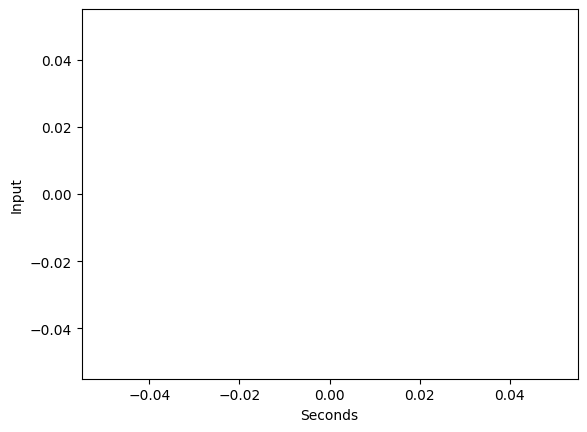

In [ ]:
# Creates the CustomInput object for our input torque sequence
custom_torques = CustomInput(-1,1)
# Starts recording a new torque sequence
custom_torques.record()

In [ ]:
import numpy as np

### Simulate the result

Now we will simulate the effects of the input you recorded.

Keep the default parameters for now, but feel free to modify later.

In [ ]:
#@markdown How long you want the simulation to run for
end_time = 10 #@param{type:"slider", min:5.0, max:30, step:1}
# The starting angle of the arm
start_angle = 0.0
dt = 0.05 # the length of the time step
#@markdown Toggle animation of figures on or off. Turning all off will result in quick results.
animate_plots = True #@param {type:"boolean"}
animate_sim = True #@param{type:"boolean"}
time_list = np.arange(0, end_time, dt)
list_len = len(time_list)
ang_hist = []
goal_ang_interp = []

# Initialize the RobotArm and save as my_robot_arm
my_robot_arm = RobotArm(start_angle, dt)

# Takes our custom torque input and interpolates it for all time steps
torques_interp = interp_values(custom_torques.values, end_time, dt)

# Loop over the time steps
for i in range(list_len):
    my_robot_arm.step_forward(torques_interp[i])
    ang_hist.append(my_robot_arm.get_ang_position())

display_results(goal_ang_interp)

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

You can go back and try different torque sequences. Run the torque input cell again to put in new sequence and then run the simulate again to see the results.

### Follow a goal path

Now we will see if we can get the arm to do something a bit challenging. See if you can get the arm to follow as closely as follows in the example below:

<img src="https://raw.githubusercontent.com/bradygm/PID-controller-simulator/main/media/animation.gif" alt="drawing" width="300"/>
<img src="https://raw.githubusercontent.com/bradygm/PID-controller-simulator/main/media/squareWave2.png" alt="drawing" width="360"/>

Obviously the arm can't teleport from one side to the other, but do your best to get your arm to the goal positions as quickly as possible. Go to the right, then stop the arm. Go to the left, and stop the arm.

This is pretty tricky, but give it a couple attempts with the code cells below.

In order to more quickly see your results from the simulation, you can choose to **temporarily turn off the animations**. You can always turn it back on whenever to see your final results. Or leave it on all the time if you have great patience 😉.

In [ ]:
# Creates the CustomInput object for our input torque sequence
custom_torques_square = CustomInput(-1,1)
# Starts recording a new torque sequence
custom_torques_square.record()

In [ ]:
#@markdown How long you want the simulation to run for
end_time = 11 #@param{type:"slider", min:5.0, max:30, step:1}
period = 10.0
# The starting angle of the arm
start_angle = 0.0
#@markdown Toggle animation of figures on or off. Turning all off will result in quick results.
animate_plots = True #@param {type:"boolean"}
animate_sim = True #@param{type:"boolean"}

dt = 0.05 # the length of the time step
time_list = np.arange(0, end_time, dt)
list_len = len(time_list)

# Initialize the RobotArm and save as my_robot_arm
my_robot_arm = RobotArm(start_angle, dt)

# Takes our custom torque input and interpolates it for all time steps
torques_interp = interp_values(custom_torques_square.values, end_time, dt)
ang_hist = []
goal_ang_interp = signal.square(2 * np.pi * time_list/period)

# Loop over the time steps
for i in range(list_len):
    my_robot_arm.step_forward(torques_interp[i])
    ang_hist.append(my_robot_arm.get_ang_position())

display_results(goal_ang_interp)

## PID Controller Magic

That was hard, right? Now that we have tried a couple times to get the arm to follow the goal path, we are now going to write a controller to have it do the hard work for us!



### P Controller

First, let's start with creating a proportional controller (the "P" part of PID). We will create a function called `p_controller` that takes in the variables `P`, `goal_position`, and `current_position`. What we want to do use those three variablesis to determine what the control input (torque) should be.

The first step is to find the difference between where we want the arm to be, the goal position, and where it is now, the current position. This is called the error, and we calculate it in function for you as `error = goal_position-current_position`.

Using the error, we can then calculate what our torque `u` should be. We do this by multiplying the error by the value `P` to determine how strongly the arm should react to a given error. We will be playing around with the value of `P` to create the arm movement we are looking for.

**Fill in the rest of the equation** of `u=` where it will set the value of the `u` to whatever you put on the right side of the equation. This `u` is what the torque will be and it is returned as the output of this function. If you're new to coding, you use the "*" symbol for multiplying numbers.

In [ ]:
def p_controller(P, goal_position, current_position):
    # We first calculate the error
    error = goal_position-current_position
    # ADD YOUR CODE HERE
    u =error*P
    return u

Run the code block with your new `p_controller` function, and then let's test it out on the simulation!



If you need help or want to double check your answer, double click on this cell to see an example solution.

<!--

u = P*error

-->

The code block below is very similar to the one before, but it now has two additional parameters. It has the `P` variable which we pass into our new function `p_controller` when calculating the torque here `torque = p_controller(P, goal_ang_interp[i], my_robot_arm.get_ang_position())` at every time step.

Give it a try with the default values first to see the results. Note that we have turned off the animations by default for quicker results.

In [ ]:
#@markdown How long you want the simulation to run for
end_time = 30 # @param {type:"slider", min:5, max:40, step:1}
#@markdown The length of each cycle of our square wave goal position
period = 60 #@param{type:"slider", min:1, max: 60.0, step:1}
# The starting angle of the arm
start_angle = 0.0
#@markdown Toggle animation of figures on or off. Turning all off will result in quick results.
animate_plots = True #@param{type:"boolean"}
animate_sim = True #@param{type:"boolean"}

dt = 0.05 # the length of the time step
time_list = np.arange(0, end_time, dt)
list_len = len(time_list)

#@markdown Proportional Gain
P = 0.05 #@param{type:"slider", min:0.01, max:5.0, step:0.01}

# Initialize the RobotArm and save as my_robot_arm
my_robot_arm = RobotArm(start_angle, dt)

torques_interp = []
ang_hist = []
goal_ang_interp = signal.square(2 * np.pi * time_list/period)

for i in range(list_len):
    torque = p_controller(P, goal_ang_interp[i], my_robot_arm.get_ang_position())
    torques_interp.append(torque) # save torque so we can draw it
    my_robot_arm.step_forward(torque)
    ang_hist.append(my_robot_arm.get_ang_position()) # save angle so we can draw it

display_results(goal_ang_interp)

How did it do? Try a couple different values for P by moving the slider in the code block above and running the cell again to see how close you can get the arm to follow the goal.

The other parameter we added to the code block above is called `period` which allows you to adjust the length of each cycle of the square wave which we use as the goal angle of the arm. Go ahead and max out the end time and the period length in order to see longer time behaviors of the system.

One thing you can try is maxing out the end time, period, and the P value. What happens? You may see that the oscillations actually start to get bigger and bigger as time goes on. This is an **unstable** system.

Now try with a lower `P` value, something like 0.05. You will see that there are less oscillations, but it gets to the goal angle much too slow, especially to follow the original square wave with a period of 10.

### PD Controller

How can we improve upon the proportional controller? We want to find the balance of moving quickly to the goal angle, but not move too quickly which leads to overshooting.

**PD controller to the rescue!**

We can add in another part to our controller the keeps our arm from moving too quickly, or having too large of a velocity. We do this by multiplying our velocity by a scaling value `D` and subtracting it from our control input `u`.

We are now ready to create our new function `pd_controller` which is similar to `p_controller` which we created before. We've added two new inputs to the function: `D` and `current_velocity`. We again have the equation `u=` where we will again have our error multiplied by `P`. But we will also subtract `D` multiplied by `current_velocity`. After writing in what we need for the function, run the cell so we can use it in our simulation.

In [ ]:
def pd_controller(P, D, goal_position, current_position, current_velocity):
    # We first calculate the error
    error = goal_position-current_position
    # ADD YOUR CODE HERE
    u = P*error - D*current_velocity
    return u

Again, if you need help or want to double check your answer, double click on this cell to see an **example solution**.

<!--

u = P*error - D*current_velocity

-->

The code block below will again look similar as to before but with a new parameter `D` that we can adjust and is passed into our function `pd_controller`. Give it a try with adjusting the `P` and `D` values and running the code block to see the results.  

In [ ]:
#@markdown Name for submitted results
username = "AnonymousUser" #@param {type:"string"}
#@markdown How long you want the simulation to run for
end_time = 30 #@param{type:"slider", min:5.0, max:30, step:1}
#@markdown The length of each cycle of our square wave goal position
period = 60 #@param{type:"slider", min:1, max: 60.0, step:1}
# The starting angle of the arm
start_angle = 0.0
#@markdown Toggle animation of figures on or off. Turning all off will result in quick results.
animate_plots = True #@param{type:"boolean"}
animate_sim = False #@param{type:"boolean"}


dt = 0.05 # the length of the time step
time_list = np.arange(0, end_time, dt)
list_len = len(time_list)

#@markdown PD Parameters
P = 5 #@param{type:"slider", min:0.01, max:5.0, step:0.01}
D = 3.92 #@param{type:"slider", min:0.0, max:5.0, step:0.01}

# Initialize the RobotArm and save as my_robot_arm
my_robot_arm = RobotArm(start_angle, dt)

torques_interp = []
ang_hist = []
goal_ang_interp = signal.square(2 * np.pi * time_list/period)

for i in range(list_len):
    torque = pd_controller(P, D, goal_ang_interp[i], my_robot_arm.get_ang_position(), my_robot_arm.get_ang_velocity())
    torques_interp.append(torque) # save torque so we can draw it
    my_robot_arm.step_forward(torque)
    ang_hist.append(my_robot_arm.get_ang_position()) # save angle so we can draw it

submit_response(Name=username)
display_results(goal_ang_interp)


User AnonymousUser6395 total error: 8.559398029968317


<ipython-input-10-8c5c567d1136>:58: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line3.set_data(time_list[i], ang_hist[i])


7.016639709472656 sec


You will probably find that you can now crank up `P` really high if you also use `D` to offset it.

What happens if you crank `D` all the way up? If it is too high, you can see how the arm takes forever to get to the goal.

Now try adjusting the `P` and `D` values to get the best results as you can. You may have noticed that on top of the graphs of your results you will see an output saying something like "User .... Total Error ...". This is summing up the error over the ten second period and submitting your results so you can see how it compares against others. How low can the error get? Is the smallest error actually what we want? Remember that you can turn back on the animation to see how your results look.

You can view submitted results [here](https://docs.google.com/spreadsheets/d/1pbKPOv4ZjdaPNsYJWK1wwlBWOSiPoD-gEATfgp6heQs/edit?usp=sharing). *If you want to edit your name for the submission, you can modify the username in the parameters of the code block above*.

You should be able to get results with a total error less than 1.4 and smoothly gets to the goal angle in around one second.

### Test your final controller

So far we've been using our controller for a simple square wave for the goal angle sequence. But now that we have a controller that can move the arm to any angle we specify, we can input our own custom sequence for it to follow. Run the code block below and you will see a slider just like when we input a torque sequence in the beginning. Now rather than moving the slider to input the torque, we are selecting the goal angle of the arm that your controller will try to follow.

Run the block and move the slider around for **10 seconds** or so to give our arm a good challenge.



In [ ]:
# Creates the CustomInput object for our input goal angle sequence
custom_goal_angle = CustomInput(-3.14,3.14)
# Starts recording a new goal angle sequence
custom_goal_angle.record()

Now let's see how your controller does!

Copy over your `P` and `D` values that gave you the best, smooth results and run the code block to see how it performs on your custom goal sequence. This is a fun one to turn `animate_sim` back on.

In [ ]:
#@markdown How long you want the simulation to run for
end_time = 10 #@param{type:"slider", min:5.0, max:30, step:1}
# The starting angle of the arm
start_angle = 0.0
#@markdown Toggle animation of figures on or off. Turning all off will result in quick results.
animate_plots = False #@param{type:"boolean"}
animate_sim = True #@param{type:"boolean"}

dt = 0.05 # the length of the time step
time_list = np.arange(0, end_time, dt)
list_len = len(time_list)

#@markdown PD Parameters
P = 0.04 #@param{type:"slider", min:0.01, max:5.0, step:0.01}
D = 0 #@param{type:"slider", min:0.0, max:5.0, step:0.01}

# Initialize the RobotArm and save as my_robot_arm
my_robot_arm = RobotArm(start_angle, dt)

torques_interp = []
ang_hist = []
goal_ang_interp = interp_values(custom_goal_angle.values, end_time, dt)

for i in range(list_len):
    torque = pd_controller(P, D,
                           goal_ang_interp[i],
                           my_robot_arm.get_ang_position(),
                           my_robot_arm.get_ang_velocity())
    torques_interp.append(torque) # save torque so we can draw it
    my_robot_arm.step_forward(torque)
    ang_hist.append(my_robot_arm.get_ang_position()) # save angle so we can draw it

display_results(goal_ang_interp)

NameError: name 'custom_goal_angle' is not defined

How'd you do?! Feel free to go back and try different custom goal sequences to really test the limits of your controller.

One interesting thing to look at is the graph of torque on the right of the results. Do you think you could have come up with that by inputing the torque yourself? That is the magic of math and good controllers. A controller can accomplish even better results than a human, and the best part is it does it all on it's own! Even when we aren't watching!

Controllers enable many amazing systems that are all around us and are essential to the exciting new tech in the future.  


# Take-home questions and exploration

We have also included some code blocks below that allow you to mess around with more parameters for the goals, simulation, and controller.

Here are some things you can try and questions you can explore:
* Change the RobotArm parameters at the very beginning of this notebook like adjusting mass or length. How does it change the results with your controller?
* We've also added the integrator to finish off the "I" of PID. When would the integrator be needed?
* Try turning on gravity in the RobotArm and getting the arm to balance from different starting angles and mimicking the results from the presentation.
* Did you notice how the torque from our controller can sometimes peak to extremely high values? What if our motor can't output that large of a torque? In the real world, motors have limits. You can turn on torque limits and play around with how much to limit your torque.
* You can modify the amplitude of the square wave

We hope you learned something new and enjoyed this Colab.

We'd also really appreciate you taking the time to send us your feedback on this workshop through a one-question anonymous form [here](https://forms.gle/j5UVvXVqoniqXZVz5).







### Controller


In [ ]:
class PID_Controller:

    def __init__(self, k_p=1, k_i=0, k_d=0, limit_on=False, limit=0):
        self.limit_on = limit_on
        self.control_limit = limit
        self.error_sum = 0

        self.k_p = k_p
        self.k_i = k_i
        self.k_d = k_d

    def p_control(self, desired_position, current_position):
        error = desired_position-current_position
        u = self.k_p*error
        return self.limit_u(u)

    def pd_control(self, desired_position, current_position, current_velocity):
        error = desired_position-current_position
        u = self.k_p*error - self.k_d*current_velocity
        return self.limit_u(u)

    def pid_control(self, desired_position, current_position, current_velocity):
        error = desired_position-current_position
        self.error_sum += error
        u = self.k_p*error + self.k_i*self.error_sum - self.k_d*current_velocity
        return self.limit_u(u)

    def limit_u(self, u):
        if self.limit_on:
            return np.clip(u, -self.control_limit, self.control_limit)
        else:
            return u

### Sim Loop

In [ ]:
#@markdown How long you want the simulation to run for
end_time = 15 #@param{type:"slider", min:5.0, max:30, step:1}
#@markdown Goal trajectory type
goal_traj_type = 'Square Wave' #@param ["Square Wave", "Custom"]
#@markdown The length and height of each cycle of our square wave goal position
period = 60 #@param{type:"slider", min:1, max: 60.0, step:1}
amplitude = 1  #@param{type:"slider", min:0.0, max: 3.14, step:0.01}
#@markdown The starting angle of the arm
start_angle = 0.1 #@param{type:"slider", min:-3.14, max:3.14, step:0.1}
#@markdown Toggle animation of figures on or off. Turning all off will result in quick results.
animate_plots = True #@param{type:"boolean"}
animate_sim = True #@param{type:"boolean"}

dt = 0.05
time_list = np.arange(0, end_time, dt)
list_len = len(time_list)

#@markdown PID Parameters
P = 0.25 #@param{type:"slider", min:0.01, max:20.0, step:0.01}
I = 0.001 #@param{type:"slider", min:0.0, max:5.0, step:0.01}
D = 0.17 #@param{type:"slider", min:0.0, max:20.0, step:0.01}

#@markdown Torque limits
turn_on_torque_limits = True #@param{type:"boolean"}
torque_limit = 1 #@param{type:"slider", min:0.01, max:20.0, step:0.01}

# Initialize the RobotArm and save as my_robot_arm
my_robot_arm = RobotArm(start_angle, dt)
# Initialize our controller
controller = PID_Controller(P, I, D, turn_on_torque_limits, torque_limit)

torques_interp = []
ang_hist = []
if goal_traj_type=='Square Wave':
    goal_ang_interp = amplitude*signal.square(2 * np.pi * time_list/period)
else:
    goal_ang_interp = interp_values(custom_goal_angle.values, end_time, dt)

for i in range(list_len):
    torque = controller.pid_control(goal_ang_interp[i],
                                    my_robot_arm.get_ang_position(),
                                    my_robot_arm.get_ang_velocity())
    torques_interp.append(torque) # save torque so we can draw it
    my_robot_arm.step_forward(torque)
    ang_hist.append(my_robot_arm.get_ang_position()) # save angle so we can draw it

display_results(goal_ang_interp)

<ipython-input-10-8c5c567d1136>:58: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line3.set_data(time_list[i], ang_hist[i])


65.24275374412537 sec


which framework should i do tensorflow